(29, 2)
              base  Worst case
2020.0         NaN         NaN
2021.0   3925470.0   4810990.0
2022.0  18667630.0  22885710.0
2023.0  18619900.0  22850700.0
2024.0  17759000.0  21812400.0
2025.0  18492900.0  22736900.0
2026.0  17744300.0  21837300.0
2027.0  17262800.0  21266000.0
2028.0  17186000.0  21194000.0
2029.0  17741000.0  21895000.0
2030.0  16985000.0  20983000.0
2031.0  16942000.0  20946000.0
2032.0  17028000.0  21070000.0
2033.0  17054000.0  21123000.0
2034.0  16885000.0  20927000.0
2035.0  16775000.0  20807000.0
2036.0  16758000.0  20805000.0
2037.0  16883000.0  20979000.0
2038.0  16712000.0  20776000.0
2039.0  16703000.0  20776000.0
2040.0  16722000.0  20817000.0
2041.0  16728000.0  20840000.0
2042.0  16671000.0  20786000.0
2043.0  16683000.0  20807000.0
2044.0  16661000.0  20795000.0
2045.0  16689000.0  20844000.0
2046.0  16650000.0  20805000.0
2047.0  16648000.0  20815000.0
2048.0  16647000.0  20825000.0
              base  Worst case
2020.0         NaN         NaN


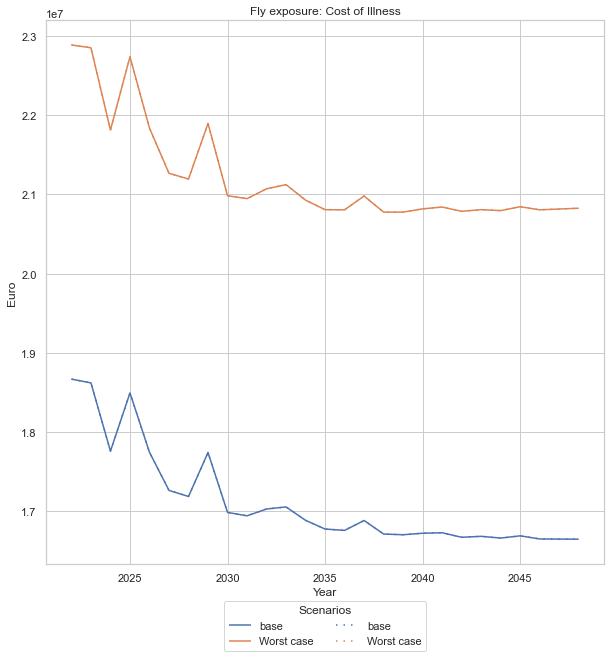

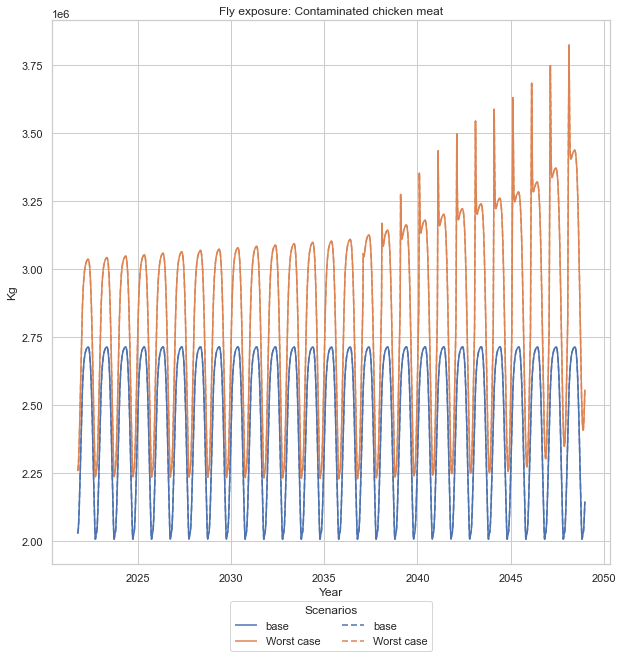

(29, 3)
        Population: medium increase  Population: large increase  \
2020.0                          NaN                         NaN   
2021.0                    3468950.0                   4362150.0   
2022.0                   16517950.0                  20723750.0   
2023.0                   16558000.0                  20592300.0   
2024.0                   15868400.0                  19567400.0   
2025.0                   16603200.0                  20300500.0   
2026.0                   16007100.0                  19405900.0   
2027.0                   15644400.0                  18810000.0   
2028.0                   15646000.0                  18660000.0   
2029.0                   16224000.0                  19192000.0   
2030.0                   15603000.0                  18307000.0   
2031.0                   15632000.0                  18195000.0   
2032.0                   15780000.0                  18222000.0   
2033.0                   15873000.0                  1

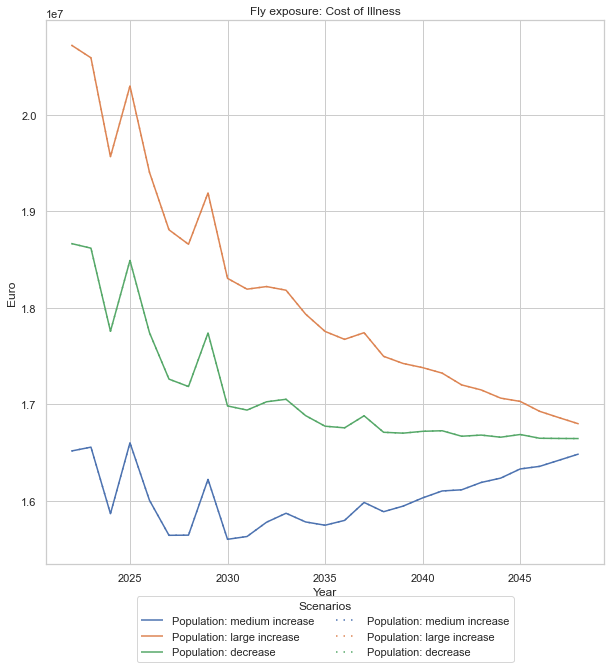

KeyboardInterrupt: 

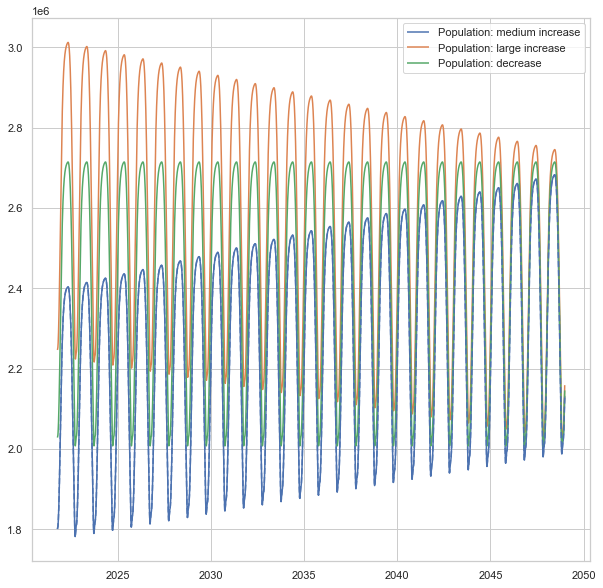

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
from enum import Enum


def _processing(df, scenarios):
    global namedict
    df = df.loc[df.index.str.split("_").str[-1].isin(scenarios)].T
    df.columns = scenarios
    df.columns = df.columns.to_series().apply(lambda value: namedict[value.split("_")[-1]])
    df.index = df.index.astype("float")
    return df


def _coi_processing(df, scenarios):
    df = _processing(df, scenarios)
    # get each year
    df = df[df.index % 1 == 0].copy()
    # only care about the difference
    return df.diff(axis=0)


def _meat_processing(df, scenarios):
    df = _processing(df, scenarios)
    if df.empty:
        return df
    min_idx, max_idx = min(df.index), max(df.index)
    # for truncation
    df = df.groupby(np.arange(len(df)) // 4, as_index=False).mean()
    idx = pd.DataFrame(np.arange(min_idx, max_idx, (max_idx - min_idx) / df.shape[0]))
    df = pd.concat([idx, df], axis=1)
    df.set_index(0, inplace=True)
    df.index.name = None
    df.index = df.index.astype("float")
    return df


def data_processing(loc):
    location = "../data/" + loc + ".txt"
    df = pd.read_csv(location, delimiter="\t", dtype="string")
    df = df.iloc[:, :-1]
    # Ok, so as we all know Python is retarded when it comes to memory allocation, which means we have to resort ugly constructs like this
    # C++ for the win
    temp = df.iloc[:, 1:].applymap(lambda value: float(value.replace("M", '')) * 1000000 if "M" in value else value)
    temp = temp.apply(pd.to_numeric)
    df = pd.concat([df.iloc[:, 0], temp], axis=1)
    # df = pd.DataFrame(df.iloc[:,0]).join(temp)
    df.set_index("Date", inplace=True)
    return df


def get_data(DATA, df, scenarios):
    df = pd.DataFrame(df.loc[data_df.index.str.contains(DATA.value)])
    if DATA in [DATA.COI, DATA.DALY]:
        return _coi_processing(df, scenarios)
    else:
        return _meat_processing(df, scenarios)

#What's the name of ur file?
loc = "fe_data"

#What's ur policy called?
policy = "Fly exposure"

bw = ["base", "12"]
po = ["1", "2", "3"]
t = ["4", "5", "6"]
s = ["7","8"]
pu = ["9", "10"]

scenario_dict= {"Base and Worst Case": bw,
                "Population": po,
                "Temperature": t,
                "Seasonal": s,
                "Public health": pu}

# What scenarios do u want plotted from policy?
scenarioss = [bw, po, t,s, pu]

namedict = {"base": "base",
            "1": "Population: medium increase",
            "2": "Population: large increase",
            "3": "Population: decrease",
            "4": "Temperature: increase 1 degree",
            "5": "Temperature: increase 1.5 degrees",
            "6": "Temperature: increase 2 degrees",
            "7": "Seasonality: no temperature change",
            "8": "Seasonality: Fast temperature change",
            "9": "Seasonality: linear temperature change",
            "10": "Public health: 10% fewer symptoms",
            "11": "Public health: 10% more symptoms",
            "12": "Worst case"}

class DATA(Enum):
    COI = "Cost of Illness"
    DALY = "DALY"
    MEAT = "contaminated meat"
    ENVH = "rate of human infection from environment"
    ENVC = "rate of chicken infection from environment"

# Because we like colour consistency
simulcmap = "viridis"
cmap = plt.cm.get_cmap(simulcmap, len(namedict))
cmapcolors = cmap(range(len(namedict)))

for name, scenarios in scenario_dict.items():
    base_scenarios = scenarios
    num_scen = len(scenarios) if len(scenarios) > len(base_scenarios) else len(base_scenarios)
    colors = np.array([list(cmapcolors[int(x)]) if x != "base" else list(cmapcolors[0]) for x in scenarios])
    colors_base = np.array([list(cmapcolors[int(x)]) if x != "base" else list(cmapcolors[0]) for x in base_scenarios])

    data_df = data_processing(loc)

    ##for some reason the function won't run anymore... w/e

    location = "../data/" + loc + ".txt"
    df = pd.read_csv(location, delimiter="\t", dtype="string")
    df = df.iloc[:, :-1]
    # Ok, so as we all know Python is retarded when it comes to memory allocation, which means we have to resort ugly constructs like this
    temp = df.iloc[:, 1:].applymap(lambda value: float(value.replace("M",'')) * 1000000 if "M" in value else value)
    temp = temp.apply(pd.to_numeric)
    df = pd.concat([df.iloc[:, 0], temp], axis=1)
    #df = pd.DataFrame(df.iloc[:,0]).join(temp)
    df.set_index("Date", inplace=True)
    base_df = df

    #cost of illness

    policy_coi = get_data(DATA.COI, data_df, scenarios)
    base_coi = get_data(DATA.COI, base_df, base_scenarios)
    print(base_coi.shape)
    print(base_coi)
    print(policy_coi)
    fig, ax = plt.subplots(figsize=(10, 10))

    if policy_coi.shape[1] >= 1:
        sns.lineplot(data=policy_coi[2022:], color=colors, dashes=[(1, 0)] * len(scenarios))
    if base_coi.shape[1] >= 1:
        sns.lineplot(data=base_coi[2022:], color=colors, dashes=[(1, 4)] * len(base_scenarios))

    plt.xlabel('Year');
    plt.ylabel('Euro')
    plt.title(policy + ': Cost of Illness')
    plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0, -0.13 - (0.02 * num_scen), 1, 1),
               loc="lower center")

    plt.savefig("../images/" + loc[:2] + "_" + name +"_coi.png", dpi=300, bbox_inches='tight')
    plt.show()

    # contaminated chicken meat

    policy_meat = get_data(DATA.MEAT, data_df, scenarios)
    base_meat = get_data(DATA.MEAT, base_df, base_scenarios)

    fig, ax = plt.subplots(figsize=(10, 10))

    if policy_meat.shape[1] >= 1:
        sns.lineplot(data=policy_meat.loc[policy_meat.index >= 2021.75], color=colors, dashes=[(1, 0)] * len(scenarios))
    if base_meat.shape[1] >= 1:
        sns.lineplot(data=base_meat.loc[base_meat.index >= 2021.75], color=colors_base,
                     dashes=[(4, 2)] * len(base_scenarios))

    plt.xlabel('Year');
    plt.ylabel('Kg')
    plt.title(policy + ': Contaminated chicken meat')
    plt.legend(title="Scenarios", ncol=2, fancybox=True, bbox_to_anchor=(0, -0.13 - (0.02 * num_scen), 1, 1),
               loc="lower center")
    ax.grid(True)
    plt.savefig("../images/" + loc[:2] + "_" + name +"_meat.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Done!")